### Table of Contents

* [Chapter 1 - Imports](#chapter1)
* [Chapter 2 - Data Cleaning](#chapter2)
* [Chapter 3 - Pre-processing](#chapter3)
* [Chapter 4 - Model creation](#chapter4)
* [Chapter 5 - Model testing](#chapter5)

### Imports <a class="anchor" id="chapter1"></a>

In [39]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import pchip
from imblearn.pipeline import Pipeline
import time
from joblib import dump
from joblib import load
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [40]:
# Importing dataset
df = pd.read_csv('bank.csv', sep=';', header=0)

### Data Cleaning <a class="anchor" id="chapter2"></a>

In [41]:
# See some brief overviews
pd.set_option("display.precision", 2)
num_desc = df.describe()
num_desc.transpose()

,count,mean,std,min,25%,50%,75%,max
age,4521.0,41.17,10.58,19.0,33.0,39.0,49.0,87.0
balance,4521.0,1422.66,3009.64,-3313.0,69.0,444.0,1480.0,71188.0
day,4521.0,15.92,8.25,1.0,9.0,16.0,21.0,31.0
duration,4521.0,263.96,259.86,4.0,104.0,185.0,329.0,3025.0
campaign,4521.0,2.79,3.11,1.0,1.0,2.0,3.0,50.0
pdays,4521.0,39.77,100.12,-1.0,-1.0,-1.0,-1.0,871.0
previous,4521.0,0.54,1.69,0.0,0.0,0.0,0.0,25.0


In [42]:
# See overview of categorical variables
cat_desc = df.describe(include=object)
cat_desc.transpose()

,count,unique,top,freq
job,4521,12,management,969
marital,4521,3,married,2797
education,4521,4,secondary,2306
default,4521,2,no,4445
housing,4521,2,yes,2559
loan,4521,2,no,3830
contact,4521,3,cellular,2896
month,4521,12,may,1398
poutcome,4521,4,unknown,3705
y,4521,2,no,4000


In [43]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [45]:
# Checking values for all categorical columns
for col in df.columns:
    if df[col].dtype == object:
        print(col)
        print(df[col].unique())

job
['unemployed' 'services' 'management' 'blue-collar' 'self-employed'
 'technician' 'entrepreneur' 'admin.' 'student' 'housemaid' 'retired'
 'unknown']
marital
['married' 'single' 'divorced']
education
['primary' 'secondary' 'tertiary' 'unknown']
default
['no' 'yes']
housing
['no' 'yes']
loan
['no' 'yes']
contact
['cellular' 'unknown' 'telephone']
month
['oct' 'may' 'apr' 'jun' 'feb' 'aug' 'jan' 'jul' 'nov' 'sep' 'mar' 'dec']
poutcome
['unknown' 'failure' 'other' 'success']
y
['no' 'yes']


In [46]:
# Checking for null values
df.isna().any().sum()

0

In [47]:
# Checking if any calls had a length of 0 (indicating these lines should be removed)
df[(df['duration'] == 0)]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


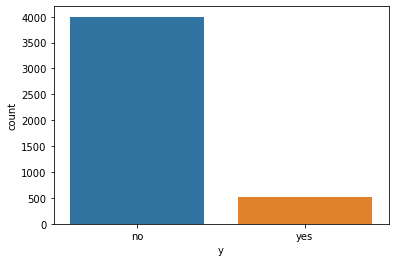

In [48]:
# Seeing distribution of deposits to see following variables in context
sns.countplot(x = 'y', data = df)
plt.show()

In [49]:
# Seeing distribution of unknown jobs
df.groupby(['y', 'job']).size()

y    job          
no   admin.           420
     blue-collar      877
     entrepreneur     153
     housemaid         98
     management       838
     retired          176
     self-employed    163
     services         379
     student           65
     technician       685
     unemployed       115
     unknown           31
yes  admin.            58
     blue-collar       69
     entrepreneur      15
     housemaid         14
     management       131
     retired           54
     self-employed     20
     services          38
     student           19
     technician        83
     unemployed        13
     unknown            7
dtype: int64

In [50]:
# dropping unknown as not too many values but could affect models
df = df[df['job'] != 'unknown']
df.groupby(['y', 'job']).size()

y    job          
no   admin.           420
     blue-collar      877
     entrepreneur     153
     housemaid         98
     management       838
     retired          176
     self-employed    163
     services         379
     student           65
     technician       685
     unemployed       115
yes  admin.            58
     blue-collar       69
     entrepreneur      15
     housemaid         14
     management       131
     retired           54
     self-employed     20
     services          38
     student           19
     technician        83
     unemployed        13
dtype: int64

In [51]:
# Seeing distribution of unknown education
df.groupby(['y', 'education']).size()

y    education
no   primary       609
     secondary    2054
     tertiary     1150
     unknown       156
yes  primary        62
     secondary     244
     tertiary      192
     unknown        16
dtype: int64

In [52]:
# dropping unknown as not too many values but could affect models
df = df[df['education'] != 'unknown']
df.groupby(['y', 'education']).size()

y    education
no   primary       609
     secondary    2054
     tertiary     1150
yes  primary        62
     secondary     244
     tertiary      192
dtype: int64

In [53]:
# Seeing distribution of balances
df.groupby(['y', 'balance']).size()

y    balance
no   -3313      1
     -2082      1
     -1746      1
     -1680      1
     -1400      1
               ..
yes   11262     1
      12569     1
      14220     1
      19317     1
      26965     1
Length: 2519, dtype: int64

In [54]:
# While there is a large distribution, seems relevant that higher balances are more likely
# to deposit than those in overdraft

In [55]:
# Seeing distribution of loans
df.groupby(['y', 'loan']).size()

y    loan
no   no      3172
     yes      641
yes  no       456
     yes       42
dtype: int64

In [56]:
# Reasonable distribution, worth keeping

In [57]:
# Seeing distribution of contact
df.groupby(['y', 'contact']).size()

y    contact  
no   cellular     2386
     telephone     240
     unknown      1187
yes  cellular      398
     telephone      40
     unknown        60
dtype: int64

In [58]:
# ~30% of values are unknown, best to drop
df.drop(['contact'], axis=1, inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,5,may,226,1,-1,0,unknown,no


In [59]:
# Seeing distribution of pdays
df.groupby(['y', 'pdays']).size()

y    pdays
no   -1       3211
      2          6
      3          1
      5          1
      7          3
              ... 
yes   461        2
      474        2
      541        1
      761        1
      804        1
Length: 361, dtype: int64

In [60]:
# ~75% of values are -1, best to drop
df.drop(['pdays'], axis=1, inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,19,oct,79,1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,11,may,220,1,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,16,apr,185,1,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,3,jun,199,4,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,5,may,226,1,0,unknown,no


In [61]:
# Seeing distribution of unknown poutcomes
df.groupby(['y', 'poutcome']).size()

y    poutcome
no   failure      409
     other        151
     success       42
     unknown     3211
yes  failure       61
     other         37
     success       75
     unknown      325
dtype: int64

In [62]:
# ~75% of values are unknown, best to drop
df.drop(['poutcome'], axis=1, inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,previous,y
0,30,unemployed,married,primary,no,1787,no,no,19,oct,79,1,0,no
1,33,services,married,secondary,no,4789,yes,yes,11,may,220,1,4,no
2,35,management,single,tertiary,no,1350,yes,no,16,apr,185,1,1,no
3,30,management,married,tertiary,no,1476,yes,yes,3,jun,199,4,0,no
4,59,blue-collar,married,secondary,no,0,yes,no,5,may,226,1,0,no


/Users/edward/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age'>

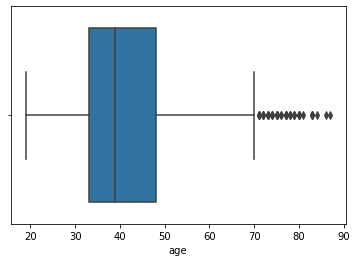

In [63]:
# Plot to view if any outliers for age
sns.boxplot(df['age'])

In [64]:
# View if any outliers in age
df.groupby('age', sort=True)['age'].count()

age
19     2
20     3
21     6
22     7
23    19
      ..
81     1
83     4
84     1
86     1
87     1
Name: age, Length: 67, dtype: int64

/Users/edward/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='campaign'>

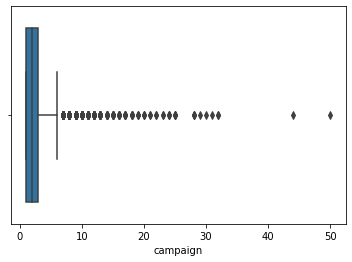

In [65]:
# Plot to view if any outliers for campaign
sns.boxplot(df['campaign'])

In [66]:
# View if any outliers in campaign
df.groupby('campaign', sort=True)['campaign'].count()

campaign
1     1640
2     1209
3      535
4      317
5      161
6      147
7       69
8       53
9       28
10      27
11      20
12      20
13      17
14      10
15       9
16       8
17       6
18       6
19       3
20       3
21       2
22       2
23       2
24       3
25       4
28       3
29       1
30       1
31       1
32       2
44       1
50       1
Name: campaign, dtype: int64

In [67]:
# Remove outliers in campaign
df = df[df['campaign'] < 33]

/Users/edward/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='previous'>

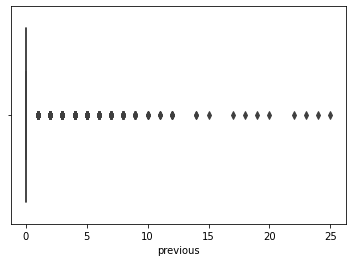

In [68]:
# Plot to view if any outliers for previous
sns.boxplot(df['previous'])

In [69]:
# View if any outliers in previous
df.groupby('previous', sort=True)['previous'].count()

previous
0     3534
1      272
2      178
3      107
4       76
5       47
6       24
7       21
8       17
9       10
10       4
11       3
12       5
14       2
15       1
17       1
18       1
19       1
20       1
22       1
23       1
24       1
25       1
Name: previous, dtype: int64

In [70]:
# Converting categorical variables to numerical
# Label Encoder used for Month (as numbers might have significance, e.g. later in the year is better)
# One Hot Encoding used for the other categorical variables to avoid significance associated with higher values
le = LabelEncoder()
df['month'] = le.fit_transform(df['month'])

df.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,previous,y
0,30,unemployed,married,primary,no,1787,no,no,19,10,79,1,0,no
1,33,services,married,secondary,no,4789,yes,yes,11,8,220,1,4,no
2,35,management,single,tertiary,no,1350,yes,no,16,0,185,1,1,no
3,30,management,married,tertiary,no,1476,yes,yes,3,6,199,4,0,no
4,59,blue-collar,married,secondary,no,0,yes,no,5,8,226,1,0,no


In [71]:
# Turning 'yes', 'no' into 1, 0
col_yes = ['default', 'housing', 'loan', 'y']
for col in col_yes:
    df[col] = df[col].apply(lambda x: 1 if x == 'yes' else 0)
df.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,previous,y
0,30,unemployed,married,primary,0,1787,0,0,19,10,79,1,0,0
1,33,services,married,secondary,0,4789,1,1,11,8,220,1,4,0
2,35,management,single,tertiary,0,1350,1,0,16,0,185,1,1,0
3,30,management,married,tertiary,0,1476,1,1,3,6,199,4,0,0
4,59,blue-collar,married,secondary,0,0,1,0,5,8,226,1,0,0


<AxesSubplot:>

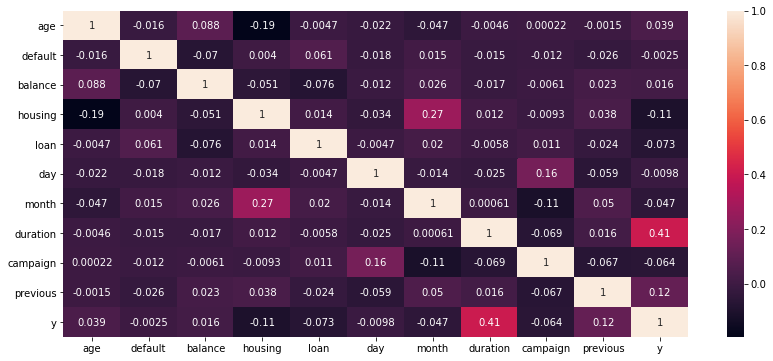

In [72]:
# Correlation matrix to see relationship between variables
plt.figure(figsize=(14,6))
sns.heatmap(df.corr(), annot=True)

In [73]:
# High duration correlation sticks out
# The duration of the call isn't known before the call happens, so isn't relavant
# for a model trying to predict the success of a call before it happens
df.drop(['duration'], axis=1, inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,day,month,campaign,previous,y
0,30,unemployed,married,primary,0,1787,0,0,19,10,1,0,0
1,33,services,married,secondary,0,4789,1,1,11,8,1,4,0
2,35,management,single,tertiary,0,1350,1,0,16,0,1,1,0
3,30,management,married,tertiary,0,1476,1,1,3,6,4,0,0
4,59,blue-collar,married,secondary,0,0,1,0,5,8,1,0,0


In [74]:
# Encoding
col_cat = ['job', 'marital', 'education']
for col in col_cat:
    df = pd.concat([df.drop(col, axis=1),pd.get_dummies(df[col], prefix=col, prefix_sep='_', dummy_na=False, drop_first=False)], axis=1)

df.head()

,age,default,balance,housing,loan,day,month,campaign,previous,y,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary
0,30,0,1787,0,0,19,10,1,0,0,...,0,0,0,1,0,1,0,1,0,0
1,33,0,4789,1,1,11,8,1,4,0,...,1,0,0,0,0,1,0,0,1,0
2,35,0,1350,1,0,16,0,1,1,0,...,0,0,0,0,0,0,1,0,0,1
3,30,0,1476,1,1,3,6,4,0,0,...,0,0,0,0,0,1,0,0,0,1
4,59,0,0,1,0,5,8,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4309 entries, 0 to 4520
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  4309 non-null   int64
 1   default              4309 non-null   int64
 2   balance              4309 non-null   int64
 3   housing              4309 non-null   int64
 4   loan                 4309 non-null   int64
 5   day                  4309 non-null   int64
 6   month                4309 non-null   int64
 7   campaign             4309 non-null   int64
 8   previous             4309 non-null   int64
 9   y                    4309 non-null   int64
 10  job_admin.           4309 non-null   uint8
 11  job_blue-collar      4309 non-null   uint8
 12  job_entrepreneur     4309 non-null   uint8
 13  job_housemaid        4309 non-null   uint8
 14  job_management       4309 non-null   uint8
 15  job_retired          4309 non-null   uint8
 16  job_self-employed    430

In [76]:
# Moving target output to end of dataframe
dfy = df.pop('y')
df['y'] = dfy
df.head()

,age,default,balance,housing,loan,day,month,campaign,previous,job_admin.,...,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,y
0,30,0,1787,0,0,19,10,1,0,0,...,0,0,1,0,1,0,1,0,0,0
1,33,0,4789,1,1,11,8,1,4,0,...,0,0,0,0,1,0,0,1,0,0
2,35,0,1350,1,0,16,0,1,1,0,...,0,0,0,0,0,1,0,0,1,0
3,30,0,1476,1,1,3,6,4,0,0,...,0,0,0,0,1,0,0,0,1,0
4,59,0,0,1,0,5,8,1,0,0,...,0,0,0,0,1,0,0,1,0,0


### Pre-processing <a class="anchor" id="chapter3"></a>

In [77]:
# Slicing into X and y
X = df[df.columns[:-1]]
y = df['y']

In [78]:
# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

In [79]:
print(len(X_train), len(X_test), len(y_train), len(X), len(y))

3231 1078 3231 4309 4309


In [80]:
# Train and Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42, stratify = y_train)

In [81]:
# Scaling the data for better training (not scaling any data used in pipelines as they will be scaled seperately)
sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [82]:
# Using SMOTE to balance data for training (only training set to avoid data leakage)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [83]:
# Turning new arrays into dataframes
X_train_smote = pd.DataFrame(X_train_smote)
y_train_smote = pd.DataFrame(y_train_smote)
X_val = pd.DataFrame(X_val)
y_val = pd.DataFrame(y_val)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

Text(0, 0.5, 'values')

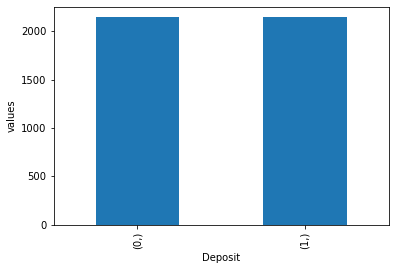

In [84]:
y_train_smote.value_counts().plot.bar()
plt.xlabel('Deposit')
plt.ylabel('values')

In [ ]:
# Saving sets to csv
X_train.to_csv('X_train.csv',index=False)

X_train_smote.to_csv('X_train_smote.csv',index=False)

X_val.to_csv('X_val.csv',index=False)

y_train.to_csv('y_train.csv',index=False)

y_train_smote.to_csv('y_train_smote.csv',index=False)

y_val.to_csv('y_val.csv',index=False)

X_test.to_csv('X_test.csv',index=False)

y_test.to_csv('y_test.csv',index=False) 

#### Loading Datasets

In [2]:
X_train = pd.read_csv("X_train.csv")
X_train_smote = pd.read_csv("X_train_smote.csv")
X_val = pd.read_csv("X_val.csv")

y_train = pd.read_csv("y_train.csv")
y_train_smote = pd.read_csv("y_train_smote.csv")
y_val = pd.read_csv("y_val.csv")

X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

### Model Creation <a class="anchor" id="chapter4"></a>

#### SVM Model Creation

In [48]:
# Running baseline SVM on unbalanced data to compare results
base_svc = SVC(kernel = 'linear', random_state = 42)
base_svc.fit(X_train.values, y_train.ravel())

SVC(kernel='linear', random_state=42)

In [49]:
# Statistics report for baseline SVM model (training)
print(classification_report(y_val, base_svc.predict(X_val.values)))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       715
           1       0.18      0.10      0.12        93

    accuracy                           0.84       808
   macro avg       0.53      0.52      0.52       808
weighted avg       0.81      0.84      0.82       808



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


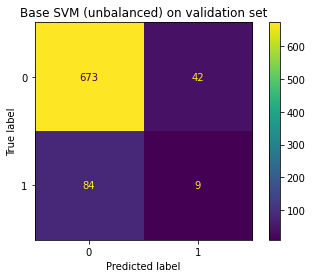

In [50]:
# Plotting confusion matrix for model
base_svc_cm = plot_confusion_matrix(base_svc, X_val, y_val)
base_svc_cm.ax_.set_title('Base SVM (unbalanced) on validation set')
plt.show()

In [50]:
# Running baseline SVM on balanced data
base_svc_smote = SVC(kernel = 'linear', random_state = 42)
base_svc_smote.fit(X_train_smote, y_train_smote.values.ravel())

SVC(kernel='linear', random_state=42)

In [50]:
# Statistics report for baseline smote SVM model (validation)
print(classification_report(y_val, base_svc_smote.predict(X_val)))

              precision    recall  f1-score   support

           0       0.91      0.64      0.75       715
           1       0.16      0.53      0.25        93

    accuracy                           0.63       808
   macro avg       0.54      0.58      0.50       808
weighted avg       0.83      0.63      0.69       808



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


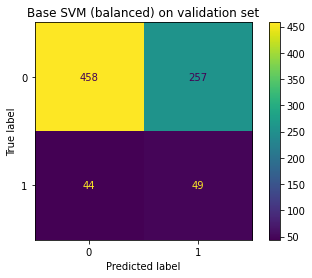

In [51]:
# Plotting confusion matrix for model
base_svc_smote_cm = plot_confusion_matrix(base_svc_smote, X_val, y_val)
base_svc_smote_cm.ax_.set_title('Base SVM (balanced) on validation set')
plt.show()

In [54]:
# Finding best SVM model
params_svc = {'svc__kernel':('linear', 'poly','rbf'), 'svc__C':[0.1, 1, 5], 'svc__degree':[2,3,4]}
pipe_svc = Pipeline(steps = [['smote', SMOTE(random_state=42)],
                             ['scaler', MinMaxScaler()],
                             ['svc', SVC(random_state=42)]])
                    
svc = GridSearchCV(pipe_svc, params_svc, cv = 5, scoring = 'recall', return_train_score=True, verbose=True)

start_pipe_svc = time.time()
svc.fit(X_train.values, y_train.values.ravel())
end_pipe_svc = time.time()

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [55]:
print(f'Training time: {end_pipe_svc - start_pipe_svc}')

Training time: 55.99348449707031


In [56]:
# Observe best score and parameters
print(svc.best_score_, svc.best_params_)

0.13571428571428573 {'svc__C': 5, 'svc__degree': 4, 'svc__kernel': 'poly'}


In [57]:
# Statistics report for best SVM model (validation)
print(classification_report(y_val, svc.predict(X_val)))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       715
           1       0.15      0.31      0.20        93

    accuracy                           0.72       808
   macro avg       0.52      0.54      0.52       808
weighted avg       0.81      0.72      0.76       808



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


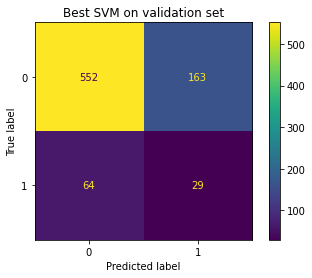

In [58]:
# Plotting confusion matrix for model
svc_val_cm = plot_confusion_matrix(svc, X_val, y_val)
svc_val_cm.ax_.set_title('Best SVM on validation set')
plt.show()

In [84]:
# See results for each set of parameters
svc_result = pd.DataFrame(svc.cv_results_)
svc_result = svc_result[['param_svc__kernel', 'param_svc__C', 'param_svc__degree', 'mean_train_score']]
svc_result.columns = ['Kernel', 'C', 'Degree', 'Score']
pd.set_option('display.float_format', lambda x: '%0.5f' % x)
#pd.reset_option('display.float_format')
print(svc_result)

    Kernel       C Degree   Score
0   linear 0.10000      2 0.00714
1     poly 0.10000      2 0.02321
2      rbf 0.10000      2 0.00000
3   linear 0.10000      3 0.00714
4     poly 0.10000      3 0.04464
5      rbf 0.10000      3 0.00000
6   linear 0.10000      4 0.00714
7     poly 0.10000      4 0.10089
8      rbf 0.10000      4 0.00000
9   linear       1      2 0.00000
10    poly       1      2 0.01607
11     rbf       1      2 0.02500
12  linear       1      3 0.00000
13    poly       1      3 0.12679
14     rbf       1      3 0.02500
15  linear       1      4 0.00000
16    poly       1      4 0.23661
17     rbf       1      4 0.02500
18  linear       5      2 0.00000
19    poly       5      2 0.05982
20     rbf       5      2 0.17500
21  linear       5      3 0.00000
22    poly       5      3 0.27411
23     rbf       5      3 0.17500
24  linear       5      4 0.00000
25    poly       5      4 0.39286
26     rbf       5      4 0.17500


In [60]:
# Saving best SVM
dump(svc, 'SVM_Best.joblib')
!cp SVM_Best.joblib "drive/My Drive/"

In [51]:
# Saving best SVM
dump(base_svc_smote, 'SVM_Best.joblib')
!cp SVM_Best.joblib "drive/My Drive/"

#### MLP Model Creation

In [61]:
# Creating baseline MLP with default values
# Baseline parameters from paper here https://link.springer.com/chapter/10.1007/978-3-319-46681-1_7?noAccess#Sec6
base_mlp = MLPClassifier(hidden_layer_sizes = 10, learning_rate_init = 0.3, max_iter = 100, random_state = 42)
base_mlp.fit(X_train_smote, y_train_smote.values.ravel())

MLPClassifier(hidden_layer_sizes=10, learning_rate_init=0.3, max_iter=100,
              random_state=42)

In [62]:
# Statistics report for baseline MLP (validation)
print(classification_report(y_val, base_mlp.predict(X_val)))

              precision    recall  f1-score   support

           0       0.91      0.10      0.17       715
           1       0.12      0.92      0.21        93

    accuracy                           0.19       808
   macro avg       0.51      0.51      0.19       808
weighted avg       0.82      0.19      0.18       808



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


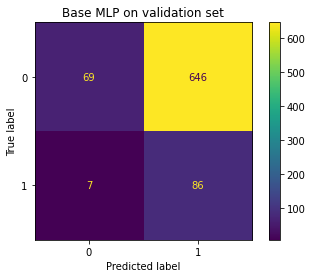

In [63]:
mlp_base_cm = plot_confusion_matrix(base_mlp, X_val, y_val)
mlp_base_cm.ax_.set_title('Base MLP on validation set')
plt.show()

In [64]:
# Finding best MLP model
params_mlp = {'mlp__hidden_layer_sizes':[50, 100, 200], 'mlp__learning_rate_init':[0.05, 0.1, 0.3], 'mlp__activation':['logistic', 'tanh', 'relu']}
pipe_mlp = Pipeline(steps = [['smote', SMOTE(random_state=42)],
                             ['scaler', MinMaxScaler()],
                             ['mlp', MLPClassifier(max_iter = 300, random_state = 42)]])
                    
mlp = GridSearchCV(pipe_mlp, params_mlp, cv = 5, scoring = 'recall', return_train_score=True, verbose=True)

start_pipe_mlp = time.time()
mlp.fit(X_train.values, y_train.values.ravel())
end_pipe_mlp = time.time()

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [65]:
print(f'Training time: {end_pipe_mlp - start_pipe_mlp}')

Training time: 402.95757961273193


In [66]:
# Observe best score and parameters
print(mlp.best_score_, mlp.best_params_)

0.29285714285714287 {'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': 200, 'mlp__learning_rate_init': 0.1}


In [67]:
# Statistics report for best MLP (validation)
print(classification_report(y_val, mlp.predict(X_val)))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       715
           1       0.13      0.15      0.14        93

    accuracy                           0.79       808
   macro avg       0.51      0.51      0.51       808
weighted avg       0.80      0.79      0.79       808



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


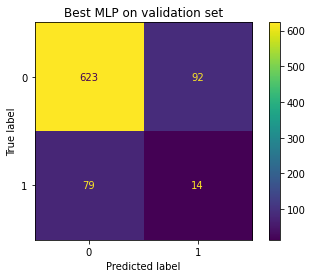

In [68]:
mlp_val_cm = plot_confusion_matrix(mlp, X_val, y_val)
mlp_val_cm.ax_.set_title('Best MLP on validation set')
plt.show()

In [79]:
# See results for each set of parameters
mlp_result = pd.DataFrame(mlp.cv_results_)
mlp_result = mlp_result[['param_mlp__hidden_layer_sizes', 'param_mlp__learning_rate_init', 'param_mlp__activation', 'mean_test_score']]
mlp_result.columns = ['Hidden Layers', 'Learning Rate', 'Activation', 'Score']
#pd.set_option('display.float_format', lambda x: '%0.5f' % x)
print(mlp_result)

   Hidden Layers Learning Rate Activation   Score
0             50       0.05000   logistic 0.15714
1             50       0.10000   logistic 0.18571
2             50       0.30000   logistic 0.12143
3            100       0.05000   logistic 0.19286
4            100       0.10000   logistic 0.22857
5            100       0.30000   logistic 0.18929
6            200       0.05000   logistic 0.21071
7            200       0.10000   logistic 0.17857
8            200       0.30000   logistic 0.11071
9             50       0.05000       tanh 0.19286
10            50       0.10000       tanh 0.15714
11            50       0.30000       tanh 0.16071
12           100       0.05000       tanh 0.20357
13           100       0.10000       tanh 0.13571
14           100       0.30000       tanh 0.20714
15           200       0.05000       tanh 0.19643
16           200       0.10000       tanh 0.29286
17           200       0.30000       tanh 0.27500
18            50       0.05000       relu 0.16786


In [ ]:
# Saving best MLP
dump(mlp, 'MLP_Best.joblib')
!cp MLP_Best.joblib "drive/My Drive/"

### Model Testing <a class="anchor" id="chapter5"></a>

In [23]:
# Loading test sets (filepath may be different depending on where you run this notebook)
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [14]:
# Loading models (filepath may be different depending on where you run this notebook)
svc = load("SVM_Best.joblib")
mlp = load("MLP_best.joblib")

#### SVM Testing

In [35]:
# Statistics report for best SVM
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.65      0.76       953
           1       0.18      0.57      0.27       125

    accuracy                           0.64      1078
   macro avg       0.55      0.61      0.52      1078
weighted avg       0.83      0.64      0.71      1078



/Users/edward/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


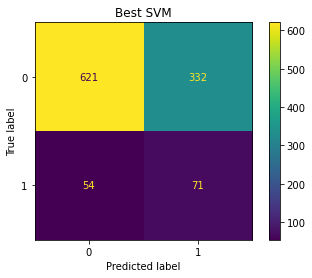

In [25]:
# Best SVM confusion matrix
svc_cm = plot_confusion_matrix(svc, X_test, y_test)
svc_cm.ax_.set_title('Best SVM')
plt.show()

/Users/edward/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


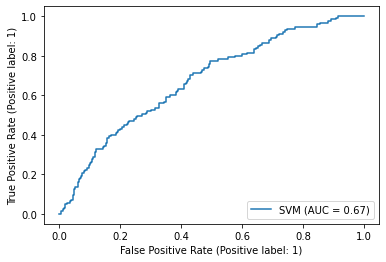

In [26]:
# ROC curve for best SVM
metrics.plot_roc_curve(svc, X_test, y_test, name='SVM')

#### MLP Testing

In [30]:
# Statistics report for best MLP
print(classification_report(y_test.values.ravel(), mlp.predict(X_test.values)))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       953
           1       0.15      0.17      0.16       125

    accuracy                           0.79      1078
   macro avg       0.52      0.52      0.52      1078
weighted avg       0.80      0.79      0.80      1078



/Users/edward/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


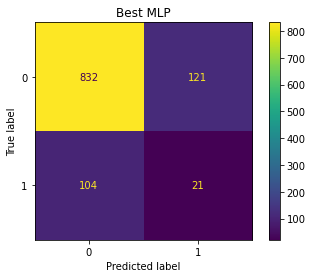

In [32]:
# Best MLP confusion matrix
mlp_cm = plot_confusion_matrix(mlp, X_test.values, y_test.values.ravel())
mlp_cm.ax_.set_title('Best MLP')
plt.show()

/Users/edward/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


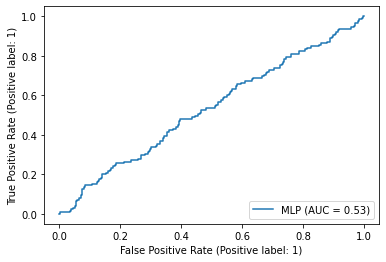

In [36]:
# ROC curve for best MLP
metrics.plot_roc_curve(mlp, X_test.values, y_test.values.ravel(), name='MLP')